In [2]:
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests

device = "mps" if torch.cuda.is_available() else "cpu"
print(device)
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

# Load image
image_path = "./cats.jpg"
image = Image.open(image_path).convert("RGB")

# Segment using text prompt
inputs = processor(images=image, text="cats", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# Post-process results
results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

print(f"Found {len(results['masks'])} objects")
# Results contain:
# - masks: Binary masks resized to original image size
# - boxes: Bounding boxes in absolute pixel coordinates (xyxy format)
# - scores: Confidence scores


cpu


Loading weights: 100%|██████████| 1468/1468 [00:01<00:00, 1367.91it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]                       


The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
Found 1 objects


Number of masks: 1
Mask shape: torch.Size([333, 500])


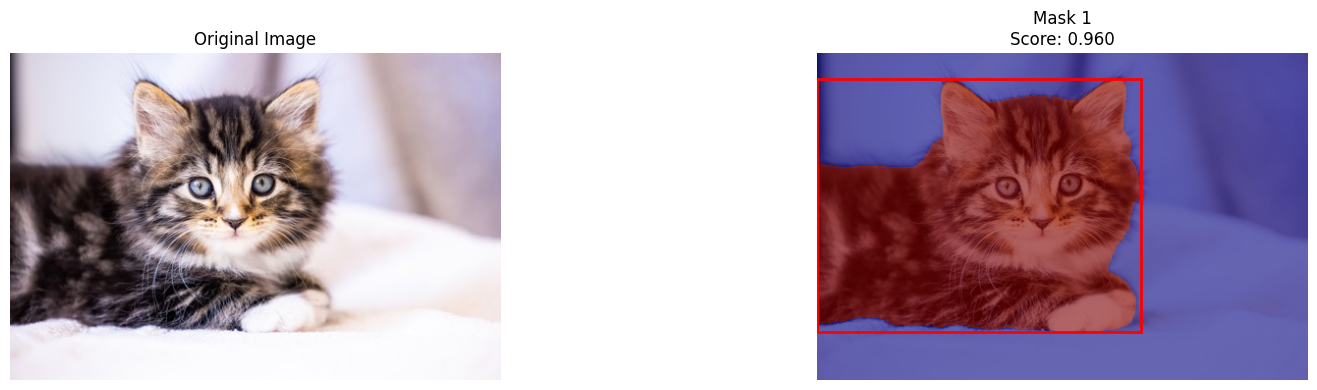

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Load the original image
image = Image.open(image_path).convert("RGB")

# Get results
masks = results['masks']
boxes = results['boxes']
scores = results['scores']

print(f"Number of masks: {len(masks)}")
print(f"Mask shape: {masks[0].shape if len(masks) > 0 else 'No masks'}")

# Plot all masks overlaid on the image
fig, axes = plt.subplots(1, min(6, len(masks) + 1), figsize=(18, 4))

# Handle single axis case
if len(masks) == 0:
    axes = [axes]
elif not hasattr(axes, '__iter__'):
    axes = [axes]

# Show original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Show each mask
for idx in range(min(5, len(masks))):
    mask = masks[idx].cpu().numpy()
    box = boxes[idx].cpu().numpy()
    score = scores[idx].item()
    
    axes[idx + 1].imshow(image)
    axes[idx + 1].imshow(mask, alpha=0.6, cmap='jet')
    
    # Add bounding box
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                         fill=False, edgecolor='red', linewidth=2)
    axes[idx + 1].add_patch(rect)
    
    axes[idx + 1].set_title(f"Mask {idx+1}\nScore: {score:.3f}")
    axes[idx + 1].axis('off')

plt.tight_layout()
plt.savefig("masks_visualization.png", dpi=150, bbox_inches='tight')
plt.show()